# 03a-splicebert_prediction-donor.ipynb: Splicing propensity and donor site classification using SpliceBERT
Analyses splicing propensity and classifies HBV splice donor sites using SpliceBERT, leveraging transformer-based sequence representations to identify predictive features. Includes performance metrics evaluation and splice donor site conservation analysis to assess model accuracy and evolutionary constraints, respectively.

In [1]:
import sys
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from tqdm.auto import tqdm
tqdm.pandas()

import logging
logging.basicConfig(level=logging.ERROR, format='%(levelname)s: %(message)s')


scripts_dir = os.path.abspath(os.path.join(os.getcwd(), '../scripts'))

if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)
    
from common import extract_quadruplet_rows, performance_metrics, fasta_to_dataframe, substitute_splice_motifs, get_non_substring_segments, bootstrap_conservation
from splicebert_helpers import predict_with_sliding_window, cal_metric_by_group

Load SpliceBERT pretrained model and a fine-tuned donor checkpoint

In [2]:
SPLICEBERT_510 = "../src/SpliceBERT/models/SpliceBERT.510nt/"
tokenizer = AutoTokenizer.from_pretrained(SPLICEBERT_510)

# Donor checkpoint
weights = "../src/SpliceBERT/examples/04-splicesite-prediction/output/finetune_splicebert_on_spliceator_GS-GS_1_donor_cv/fold0/checkpoint.pt.best_model.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(SPLICEBERT_510, num_labels=1).to(device)

# Load the checkpoint dictionary
checkpoint = torch.load(weights, map_location="cpu")
model_state_dict = checkpoint["model"]

# Remove the missing key
if "bert.embeddings.position_ids" in model_state_dict:
    del model_state_dict["bert.embeddings.position_ids"]

model.load_state_dict(model_state_dict, strict=False)
model.eval()

Some weights of the model checkpoint at ../src/SpliceBERT/models/SpliceBERT.510nt/ were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ..

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(10, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elem

Extend consensus fasta sequences by adding 200-nt flanking sequences to the upstream of PreC ORF and the downstream of X ORF

In [ ]:
! paste \
    <(grep ">" ../ref/hbvdb/all_Genomes.fasta) \
    <(awk 'BEGIN{RS=">"}NR>1{sub("\n","\t"); gsub("\n",""); print RS$0}' ../ref/hbvdb/all_Genomes.fasta | cut -f2 | cut -c1679-) \
    <(awk 'BEGIN{RS=">"}NR>1{sub("\n","\t"); gsub("\n",""); print RS$0}' ../ref/hbvdb/all_Genomes.fasta | cut -f2 | cut -c-1677) \
    <(awk 'BEGIN{RS=">"}NR>1{sub("\n","\t"); gsub("\n",""); print RS$0}' ../ref/hbvdb/all_Genomes.fasta | cut -f2 | cut -c1678-2296) \
    | awk '{print $1 "\t" $2 $3 $4}' | sed 's/-/\t/;s/\t/\.fa\t/2;s/-//g' | awk 'BEGIN{OFS="\t"} {print $1, $2, length($NF), $3}' \
    > ../ref/hbvdb/pgrna/pgrna_flank200.txt

! split -l 200 ../ref/hbvdb/pgrna/pgrna_flank200.txt \
    -d ../data/processed_files/pgrna/pgrna_flank200_

Predict HBV donor sites by sliding window

In [3]:
files = sorted(glob("../data/processed_files/pgrna/pgrna_flank200_*"))

for i in files:
    path, basename = os.path.split(i)
    index = int(basename.split("_")[2])
    
    hbvdb = pd.read_csv(i, sep="\t", header=None)
    hbvdb.columns = ["tid","genotype","length","seq"]

    hbvdb["splicebert_cls"] = hbvdb.seq.progress_apply(lambda x: predict_with_sliding_window(
            x,
            model,
            tokenizer,
            max_len=400,
            stride=1, # Slide by 1 nucleotide
            dnabert_k=None,
            device=device
        ))
    hbvdb.to_pickle(f"{path}/splicebert_hbvdb_{index}.GT.pkl.gz")
    sys.stdout.write(f"\rProgress: {round((index+1)/len(files)*100)}%")
    sys.stdout.flush()

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 3%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 5%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 8%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 11%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 13%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 16%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 18%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 21%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 24%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 26%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 29%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 32%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 34%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 37%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 39%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 42%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 45%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 47%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 50%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 53%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 55%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 58%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 61%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 63%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 66%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 68%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 71%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 74%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 76%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 79%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 82%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 84%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 87%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 89%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 92%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 95%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 97%

  0%|          | 0/101 [00:00<?, ?it/s]

Progress: 100%

Process sliding window output

In [2]:
pred_donor = []

for i in glob("../data/processed_files/pgrna/splicebert_hbvdb_[0-9]*.GT.pkl.gz"):
    pred = pd.read_pickle(i)
    pred_donor.append(pred)
    
pred_donor = pd.concat(pred_donor)
pred_donor["genotype"] = pred_donor["genotype"].str.replace(".fa","")
pred_donor['seq'] = pred_donor.seq.apply(lambda x: list(x[200:-199]))
pred_donor.value_counts(["genotype","length"]).head(20)

genotype  length
C         3639      2084
B         3639      1728
D         3606      1059
A         3645       856
RF        3639       642
E         3636       301
F         3639       252
RF        3606       237
C         3621        40
G         3708        37
H         3639        27
B         3645        17
RF        3645        16
          3636        14
C         3624        14
D         3639         9
C         3597         9
D         3612         8
C         3588         7
RF        3708         7
Name: count, dtype: int64

In [3]:
pred_donor = pred_donor[(pred_donor["length"]==3639)].copy()
pred_donor["splicebert_cls"]= pred_donor["splicebert_cls"].apply(lambda x: pd.DataFrame(x))
dpreds = pd.concat(pred_donor["splicebert_cls"].tolist())
dpreds[0] = dpreds[0].apply(lambda x: x-200)
dpreds.columns = ["position","logit","prob"]
dpreds.reset_index(drop=True, inplace=True)
dpreds["id"] = pred_donor["tid"].repeat(3240).reset_index().tid
dpreds = pd.merge(dpreds, pred_donor[["tid","genotype"]].rename(columns={"tid":"id"}))
dpreds["base"] = list(np.concatenate(pred_donor["seq"].tolist()))

In [4]:
dset = dpreds[dpreds.genotype.str.contains("B|C|RF|F")].copy()
dset = dset[~dset.genotype.str.contains("RFC")].copy()
dsl = dset.groupby(["id","genotype"]).logit.apply(list).reset_index()

Dimensional reduction and clustering

In [5]:
import scanpy as sc

adata = sc.AnnData(np.array(dsl.logit.tolist()))
adata.obs["id"] = dsl["id"].tolist()
adata.obs["genotype"] = dsl["genotype"].tolist()

sc.pp.pca(adata, n_comps=128, random_state=0)
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=50)
sc.tl.umap(adata, random_state=0)
sc.tl.leiden(adata, resolution=0.2)

/tmp/ipykernel_665664/3916490363.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.2)


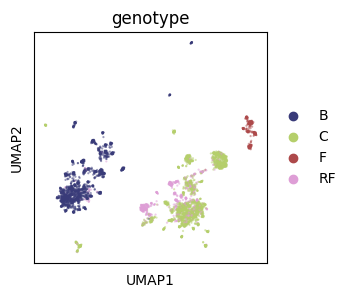

<Figure size 640x480 with 0 Axes>

In [6]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(adata, ax=ax, color="genotype", size=10, palette="tab20b", alpha=0.5)

plt.tight_layout()

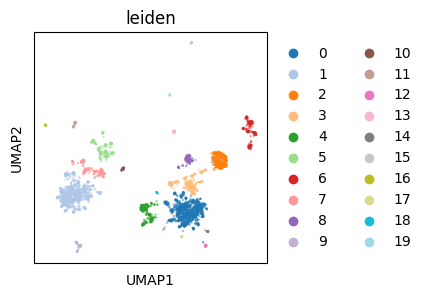

<Figure size 640x480 with 0 Axes>

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(adata, ax=ax, color="leiden", size=10, palette="tab20", alpha=0.5)

plt.tight_layout()

In [6]:
cal_metric_by_group(adata.obs["genotype"], adata.obs["leiden"], donors=adata.obs["genotype"].unique().tolist())

0.5315173426698312

Group SpliceBERT model outputs by splice site usage

In [5]:
x,gu,t,y = extract_quadruplet_rows(dset.reset_index(drop=True), "base", "G", "T", pre_value_any=True)

In [6]:
gu.drop_duplicates(["id","base"]).value_counts(["genotype","base"])

genotype  base
C         G       2084
B         G       1728
RF        G        642
F         G        252
Name: count, dtype: int64

In [7]:
cosi_long = pd.read_pickle("../data/processed_files/cosi_long.pkl.gz")
h = cosi_long[cosi_long["Splicing efficiency"]>=0.1].copy()
h["group"] = "Higher usage"

l = cosi_long[cosi_long["Splicing efficiency"]<0.1].copy()
l["group"] = "Lower usage"

hl = pd.concat([h,l])

pos = hl[hl["coSI"]=='$\\theta_5$'].copy()
pos["position"] =  pos["start"]

a = pd.merge(gu, pos[["position","group","Splicing efficiency","Splice site"]], how="left")
a = a.sort_values("Splicing efficiency", ascending=False).drop_duplicates(["position","logit","prob","id","genotype"])
a["group"] = a["group"].fillna("Non-donor")

Generate control sequences with GT splice sites uniformly substituted with AA

In [11]:
fa = fasta_to_dataframe("../ref/hbvdb/pgrna/pgrna.fa")
fa.columns = ["id","seq"]
fa["id"] = ">" + fa["id"].str.split().str[0]

au = a.dropna()
au = pd.merge(au, fa)
au = au.groupby(["id","seq"])["position"].apply(list).reset_index()
au["seq_sub"] = au.apply(lambda x: substitute_splice_motifs(x["seq"], x["position"], "GT"), axis=1)

fa_flank = pd.read_csv("../ref/hbvdb/pgrna/pgrna_flank200.txt", sep="\t", header=None)[[0,3]]
fa_flank.columns = ["id", "seq_flank"]
au = pd.merge(au, fa_flank)
au["flanks"] = au.apply(lambda x: get_non_substring_segments(x["seq_flank"], x["seq"]), axis=1)
au["seq_sub"] = au.apply(lambda x: x["flanks"][0] + x["seq_sub"] + x["flanks"][1], axis=1)
au = au[["id","seq_sub"]]
au.to_csv("../ref/hbvdb/pgrna/pgrna_flank200_GT-AA.txt", sep="\t", header=None, index=None)

In [10]:
! split -l 200 ../ref/hbvdb/pgrna/pgrna_flank200_GT-AA.txt \
    -d ../data/processed_files/pgrna/pgrna_flank200_GT-AA_

Process sliding window output for substitution control

In [3]:
files = sorted(glob("../data/processed_files/pgrna/pgrna_flank200_GT-AA_*"))

for i in files:
    path, basename = os.path.split(i)
    index = int(basename.split("_")[3])
    
    hbvdb_control = pd.read_csv(i, sep="\t", header=None)
    hbvdb_control.columns = ["tid","seq"]

    hbvdb_control["splicebert_cls"] = hbvdb_control.seq.progress_apply(lambda x: predict_with_sliding_window(
            x,
            model,
            tokenizer,
            max_len=400,
            stride=1, # Slide by 1 nucleotide
            dnabert_k=None,
            device=device
        ))
    hbvdb_control.to_pickle(f"{path}/splicebert_hbvdb_control_{index}.GT.pkl.gz")
    sys.stdout.write(f"\rProgress: {round((index+1)/len(files)*100)}%")
    sys.stdout.flush()

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 4%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 8%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 12%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 17%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 21%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 25%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 29%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 33%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 38%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 42%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 46%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 50%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 54%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 58%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 62%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 67%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 71%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 75%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 79%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 83%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 88%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 92%

  0%|          | 0/200 [00:00<?, ?it/s]

Progress: 96%

  0%|          | 0/106 [00:00<?, ?it/s]

Progress: 100%

In [2]:
pred_donor = []

for i in glob("../data/processed_files/pgrna/splicebert_hbvdb_control_*.GT.pkl.gz"):
    pred = pd.read_pickle(i)
    pred_donor.append(pred)
    
pred_donor = pd.concat(pred_donor)

fa = fasta_to_dataframe("../ref/hbvdb/pgrna/pgrna.fa")
fa["genotype"] = fa.tid.str.split().str[1].str.replace(".fa","")
fa["tid"] = ">" + fa.tid.str.split().str[0]

pred_donor = pd.merge(pred_donor, fa[["tid","genotype"]])
pred_donor["length"] = pred_donor.seq.apply(len)
pred_donor['seq'] = pred_donor.seq.apply(lambda x: list(x[200:-199]))
pred_donor.value_counts(["genotype","length"])

genotype  length
C         3639      2084
B         3639      1728
RF        3639       642
F         3639       252
Name: count, dtype: int64

In [3]:
pred_donor = pred_donor[(pred_donor["length"]==3639)].copy()
pred_donor["splicebert_cls"]= pred_donor["splicebert_cls"].apply(lambda x: pd.DataFrame(x))
dpreds = pd.concat(pred_donor["splicebert_cls"].tolist())
dpreds[0] = dpreds[0].apply(lambda x: x-200)
dpreds.columns = ["position","logit","prob"]
dpreds.reset_index(drop=True, inplace=True)
dpreds["id"] = pred_donor["tid"].repeat(3240).reset_index().tid
dpreds = pd.merge(dpreds, pred_donor[["tid","genotype"]].rename(columns={"tid":"id"}))
dpreds["base"] = list(np.concatenate(pred_donor["seq"].tolist()))

In [4]:
dset = dpreds[dpreds.genotype.str.contains("B|C|RF|F")].copy()
dset = dset[~dset.genotype.str.contains("RFC")].copy()
dsl = dset.groupby(["id","genotype"]).logit.apply(list).reset_index()

Dimensional reduction and clustering for substitution control

In [5]:
import scanpy as sc

adata = sc.AnnData(np.array(dsl.logit.tolist()))
adata.obs["id"] = dsl["id"].tolist()
adata.obs["genotype"] = dsl["genotype"].tolist()

sc.pp.pca(adata, n_comps=128, random_state=0)
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=50)
sc.tl.umap(adata, random_state=0)
sc.tl.leiden(adata, resolution=0.2)

/tmp/ipykernel_4039846/3916490363.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.2)


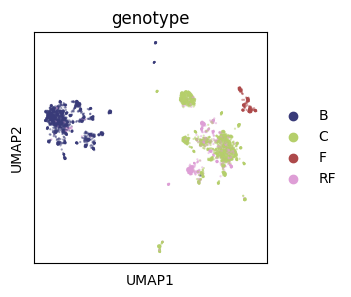

<Figure size 640x480 with 0 Axes>

In [6]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(adata, ax=ax, color="genotype", size=10, palette="tab20b", alpha=0.5)

plt.tight_layout()

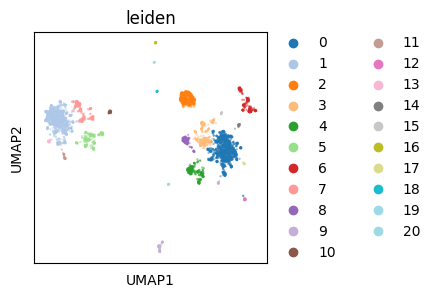

<Figure size 640x480 with 0 Axes>

In [7]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(adata, ax=ax, color="leiden", size=10, palette="tab20", alpha=0.5)

plt.tight_layout()

Note: The observed separation may arise from general genomic sequence context as substitution controls also show distinct clusters as original sequences.

##### Visualise SpliceBERT model outputs by splice site usage

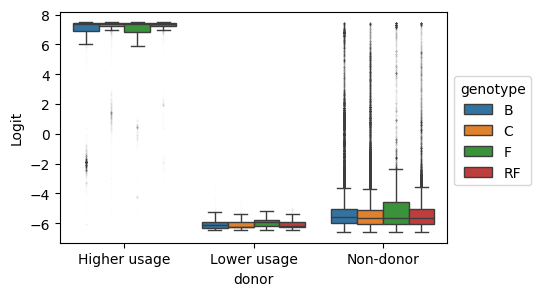

In [11]:
plt.figure(figsize=(5,3))

flierprops = dict(markersize=1, alpha=0.005)
g = sns.boxplot(data=a.sort_values("genotype"), x="group", y="logit", hue="genotype", 
                palette="tab10", flierprops=flierprops, 
                order=["Higher usage","Lower usage","Non-donor"])

plt.xlabel("donor")
plt.ylabel("Logit")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 0.75))
plt.savefig("../results/figures/fig5/logit_donors.png", bbox_inches='tight', dpi=300)

In [10]:
a.drop_duplicates(["Splice site","genotype","position"]).value_counts(["genotype","Splice site","group"])

genotype  Splice site  group       
B         donor        Higher usage    7
RF        donor        Higher usage    7
C         donor        Higher usage    6
F         donor        Higher usage    6
B         donor        Lower usage     4
C         donor        Lower usage     4
F         donor        Lower usage     4
RF        donor        Lower usage     4
Name: count, dtype: int64

In [11]:
a.drop_duplicates(["Splice site","genotype","position"]).value_counts(["Splice site","group"])

Splice site  group       
donor        Higher usage    26
             Lower usage     16
Name: count, dtype: int64

In [12]:
a.drop_duplicates(["Splice site","position"]).value_counts(["Splice site","group"])

Splice site  group       
donor        Higher usage    7
             Lower usage     4
Name: count, dtype: int64

In [13]:
a.value_counts("group")

group
Non-donor       757682
Higher usage     25840
Lower usage      14277
Name: count, dtype: int64

In [9]:
a.drop_duplicates('id').value_counts("genotype")

genotype
C     2084
B     1728
RF     642
F      252
Name: count, dtype: int64

Conservation of splice donor sites vs non-donor GU sites

In [8]:
astats = pd.merge(a[["position","group","genotype"]].drop_duplicates(), a.groupby(["position","genotype"]).logit.describe().reset_index())
gucounts = gu.drop_duplicates("id").value_counts("genotype").reset_index()
gucounts.columns = ["genotype","total sequences"]
astats = pd.merge(astats, gucounts, on="genotype")
astats["% Conserved GU sites"] = astats["count"]/astats["total sequences"] *100

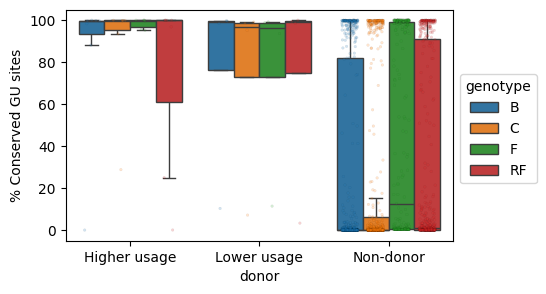

In [15]:
plt.figure(figsize=(5,3))
g = sns.boxplot(data=astats.sort_values("genotype"), x="group", y="% Conserved GU sites", hue="genotype", 
                order=["Higher usage","Lower usage","Non-donor"],
                palette="tab10", showfliers=False)
g = sns.stripplot(data=astats.sort_values("genotype"), x="group", y="% Conserved GU sites", hue="genotype", 
                  order=["Higher usage","Lower usage","Non-donor"],
                  edgecolor='black', linewidth=0.1, alpha=0.2, jitter=0.25, s=2, 
                  palette="tab10", dodge=True, legend=False)
plt.xlabel("donor")
# g.set(xlabel=None)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 0.75))
plt.savefig("../results/figures/fig5/conservation_donors.png", bbox_inches='tight', dpi=300)

In [13]:
astats.groupby(["genotype", "group"])["% Conserved GU sites"].median()

genotype  group       
B         Higher usage     99.652778
          Lower usage      99.016204
          Non-donor         0.289352
C         Higher usage     99.808061
          Lower usage      96.833013
          Non-donor         0.191939
F         Higher usage     99.801587
          Lower usage      96.230159
          Non-donor        12.698413
RF        Higher usage    100.000000
          Lower usage      98.987539
          Non-donor         1.090343
Name: % Conserved GU sites, dtype: float64

In [8]:
confidence_intervals = []

for i in a.genotype.unique():
    results = bootstrap_conservation(data=a, genotype=i, splice_site="donor")
    diffs = np.array(results["Higher usage"]) - np.array(results["Lower usage"])
    ci = np.percentile(diffs, [2.5, 97.5])
    confidence_intervals.append([i, ci[0], ci[1]])
    
confidence_intervals = pd.DataFrame(confidence_intervals)
confidence_intervals.columns = ["genotype","95% CI lower","95% CI upper"]
confidence_intervals

,genotype,95% CI lower,95% CI upper
0,C,0.100962,0.138221
1,B,0.056565,0.222543
2,RF,-0.138021,0.138021
3,F,0.013333,0.266667


Calculate performance metrics for splice donor sites

In [12]:
usage = {'Higher usage':1, 'Lower usage':1, 'Non-donor':0}

a["label"] = a.group.apply(lambda x: usage[x])

y_true = a["label"].to_numpy()
y_pred = a.logit.to_numpy()

In [13]:
performance_metrics(y_true, y_pred, 0.5)


AUROC: 0.72
AUPRC: 0.59

Predicted binary labels unique values: [0 1]

Metrics at threshold=0.5:
Accuracy: 0.95
F1-Score: 0.52
Precision: 0.47
Recall: 0.59

Classification Report at threshold=0.5:
              precision    recall  f1-score   support

Not Positive       0.98      0.97      0.97    757682
    Positive       0.47      0.59      0.52     40117

    accuracy                           0.95    797799
   macro avg       0.72      0.78      0.75    797799
weighted avg       0.95      0.95      0.95    797799

